<a href="https://colab.research.google.com/github/saraswat40/Golang-Regex-Tutorial/blob/master/Lime_YoloV4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

#verify GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

%cd /
!git clone https://github.com/AlexeyAB/darknet

# change makefile to have GPU and OPENCV enabled
# TODO: adapt for the GPU you will get in the pro version
%cd /darknet

# change makefile to have GPU and OPENCV enabled
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
#Go to runtime > manage sessions and terminate if we don't get a V100.

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Thu Feb 25 23:17:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+

In [2]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

In [19]:
%cd /darknet
import darknet as dn
import darknet_images as dn_images
import numpy as np
import matplotlib.pyplot as plt
import cv2

dn.set_gpu(0)

#weights and config from here: https://github.com/WongKinYiu/CrossStagePartialNetworks#big-models
#labels from here: https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
mdata = '/content/csresnext50.data'
weights = '/content/csresnext50.weights'
conf = '/content/csresnext50.cfg'


net = dn.load_net_custom(conf.encode('ascii'), weights.encode('ascii'), 0, 1)

net, class_names, class_colors = dn.load_network(
            conf,
            mdata,
            weights,
            batch_size=1
        )

meta = dn.load_meta(mdata.encode('ascii'))
#hippo image from here: https://www.dkfindout.com/us/animals-and-nature/hippopotamuses/ 
fname = '/content/hippo.jpg'

def batch_predict(images):
    returnprob = []
    i = 0
    for image in images:
      tmpimg = Image.fromarray(image)
      tmpFilename = "/content/" + str(i) + ".jpg"
      tmpimg.save(tmpFilename)
      i = i + 1

      cv2img = cv2.imread(tmpFilename)
      res = dn_images.image_classification(cv2img, net, class_names)

      probability = [row[1] for row in res]
      returnprob.append(probability)
      

    returnProbNDArray = np.asarray(returnprob)
    #print(returnProbNDArray.shape)
    return returnProbNDArray


/darknet


In [6]:
!pip install lime

In [20]:
import os
from PIL import Image
from lime import lime_image

def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
image = get_image(fname)

# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(image), batch_predict, top_labels=1, hide_color=0, num_samples=1000)


In [21]:
from skimage.segmentation import mark_boundaries


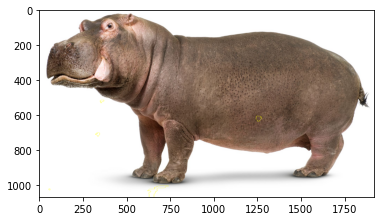

In [22]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
#print(temp)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)
